# Define a tesseroid relief mesh

There is a PrismRelief in Fatiando but we still need a TesseroidRelief. This is a mesh of tesseroids distributed along an area. Tesseroids have either the top of bottom fixed to a reference height. The other end ondulates along a relief.

In [1]:
%%writefile tesseroid_mesh.py

from __future__ import division
import copy
import numpy as np
from fatiando.mesher import Tesseroid


class TesseroidRelief(object):
    """
    Implements a relief ondulating around a reference level using tesseroids.
    """
    
    def __init__(self, area, shape, relief, reference, props=None):
        assert shape[0]*shape[1] == relief.size
        assert len(area) == 4
        assert area[0] < area[1] and area[2] < area[3]
        self.area = area
        self.shape = shape
        x1, x2, y1, y2 = area
        ny, nx = shape
        self.spacing = ((x2 - x1)/nx, (y2 - y1)/ny)
        self._relief = relief
        self.reference = reference
        self.set_top_bottom()
        if props is None:
            self.props = {}
        else:
            self.props = props
        self._i = 0
        
    def set_top_bottom(self):
        self._top = self.relief.copy()
        self._bottom = self.reference*np.ones_like(self.relief)
        isbelow = self._top <= self.reference
        self._top[isbelow] = self.reference
        self._bottom[isbelow] = self.relief[isbelow]
        
    @property
    def top(self):
        return self._top
    
    @property
    def bottom(self):
        return self._bottom
    
    @property
    def relief(self):
        return self._relief
    
    @relief.setter
    def relief(self, z):
        assert z.size == self.size
        self._relief = z
        self.set_top_bottom()
        
    @property
    def size(self):
        return self.relief.size
    
    def __len__(self):
        return self.size
    
    def __iter__(self):
        self._i = 0
        return self
    
    def next(self):
        if self._i >= self.size:
            raise StopIteration
        cell = self.__getitem__(self._i)
        self._i += 1
        return cell
    
    def __getitem__(self, index):
        ny, nx = self.shape
        x1, x2, y1, y2 = self.area
        dx, dy = self.spacing
        j = index//nx
        i = index - j*nx
        w = x1 + i*dx
        e = w + dx
        s = y1 + j*dy
        n = s + dy
        top = self.top[index]
        bottom = self.bottom[index]
        props = {}
        for p in self.props:
            props[p] = self.props[p][index]
        cell = Tesseroid(w, e, s, n, top, bottom, props)
        return cell
    
    def copy(self, deep=False):
        if deep:
            other = copy.deepcopy(self)
        else:
            other = copy.copy(self)
        return other

Overwriting tesseroid_mesh.py


In [2]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import multiprocessing
from fatiando import gridder, utils
from fatiando.vis import myv
from fatiando.gravmag import tesseroid
from tesseroid_mesh import TesseroidRelief

In [3]:
shape = (30, 30)
# Make a regular grid inside an area
area = (-40, 40, 20, 60)
lon, lat, h = gridder.regular(area, shape, z=250e3)
# The model area is slightly larger because the points generated above are in the center of each cell.
dlon, dlat = gridder.spacing(area, shape)
modelarea = (area[0] - dlon/2, area[1] + dlon/2, area[2] - dlat/2, area[3] + dlat/2)
# Make a checkerboard relief undulating along the -35km height reference
f = 0.2
reference = -35e3
relief = 10e3*np.sin(f*lon)*np.cos(f*lat) + reference

In [4]:
# The density contrast is negative if the relief is below the reference
density = 600*np.ones_like(relief)
density[relief < reference] *= -1

In [5]:
sample_mesh = TesseroidRelief(modelarea, shape, relief, reference, {'density': density})

In [6]:
def plot_result_3d(moho, fname):
    bounds = modelarea + (-20e3, -60e3)
    scale = (1, 1, 40) # Exaggerate the radial dimension
    datarange = np.abs([moho.props['density'].max(), moho.props['density'].min()]).max()
    scene = myv.figure(zdown=False)
    plot = myv.tesseroids(moho, 'density', scale=scale)
    plot.module_manager.scalar_lut_manager.show_legend = True
    plot.module_manager.scalar_lut_manager.lut_mode = 'RdYlBu'
    plot.module_manager.scalar_lut_manager.data_range = [-datarange, datarange]
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.minimum_size = np.array([1, 1])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position2 = np.array([ 0.13741855,  0.64385382])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position = np.array([ 0.03303258,  0.07342193])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.maximum_size = np.array([100000, 100000])
    plot.module_manager.scalar_lut_manager.label_text_property.color = (0, 0, 0)
    plot.module_manager.scalar_lut_manager.title_text_property.color = (0, 0, 0)
    scene.scene.camera.position = [2252864.9143914036, -5202911.2574882135, 8495162.9722945951]
    scene.scene.camera.focal_point = [3135763.9476126051, 1056258.4985192744, 829277.18542720564]
    scene.scene.camera.view_angle = 30.0
    scene.scene.camera.view_up = [0.6164057832087273, 0.57367112225287575, 0.53939350563383837]
    scene.scene.camera.clipping_range = [783483.44437851617, 16078402.004277557]
    scene.scene.camera.compute_view_plane_normal()
    scene.scene.render()
    myv.savefig(fname)
    #myv.show()
    myv.mlab.close()
    return Image(filename=fname)    

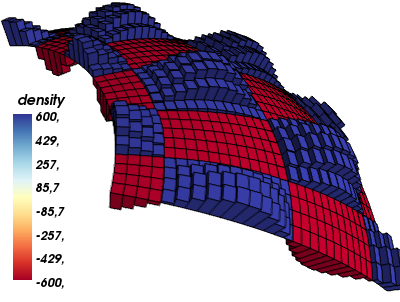

In [7]:
plot_result_3d(sample_mesh, 'example-mesh.png')

In [8]:
ncpu = multiprocessing.cpu_count()

In [9]:
gz = tesseroid.gz(lon, lat, h, sample_mesh, njobs=ncpu)
gz = utils.contaminate(gz, 0.5)

/home/leo/bin/anaconda/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


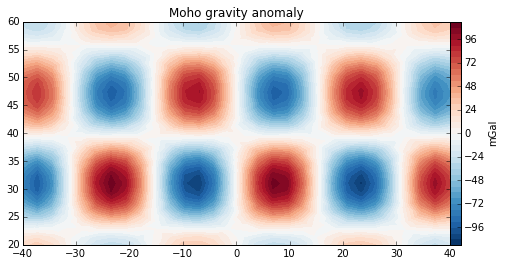

In [10]:
plt.figure(figsize=(9, 4))
plt.title('Moho gravity anomaly')
plt.tricontourf(lon, lat, gz, 40, cmap='RdBu_r')
plt.colorbar(pad=0).set_label('mGal')